In [1]:
import sys
print sys.prefix
print sys.version

/opt/mapr/EDSIADM/anaconda2/envs/pyaphp
2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


### In that notebook, we will implement the functions to normalize selected waves
The goal is to produce 4 vectors with a given dimension per selected case

## How chosing the right dimension?

In [47]:
import pyodbc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
%matplotlib inline
pd.options.mode.chained_assignment = None # to avoid pandas warnings

In [3]:
#
# Drillbit ODBC connection
#
# conn = pyodbc.connect("DSN=MapR ODBC Driver for Drill DSN", autocommit=True)
conn = pyodbc.connect("DSN=drill_eds", autocommit=True)

In [4]:
def df_from_query(conn, query):
    """
    Query an ODBC datasource and set results in a pandas Dataframe
    
    Parameters
    ----------
    pyodbc.Connection conn : Datasource ODBC connection
    string           query : query to execute on datasource
    """
    c = conn.cursor()
    c.execute(query)
    cols = [column[0] for column in c.description]
    data = []
    for row in c.fetchall():
        data.append(tuple(row))
    df = pd.DataFrame(data, columns=cols)
    return df

In [8]:
q1 = "select * from nda_j1_deces"
df1 = df_from_query(conn, q1)
df1.head()

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT


In [9]:
q2 = "select n.id_nda, n.j1, min(s.dt_insert) as dt_min, max(s.dt_insert) as dt_max \
from nda_j1_deces n, icu_sensor_util s \
where CAST(n.id_nda as VARCHAR) = CAST(s.id_nda as VARCHAR) \
and CAST(n.j1 as VARCHAR) = CAST(s.dt_deb as VARCHAR) \
group by n.id_nda, n.j1 \
order by n.id_nda, n.j1"
df2 = df_from_query(conn, q2)
df2.head()

,id_nda,j1,dt_min,dt_max
0,2744589,2014-05-08,2014-05-08 00:40:00,2014-05-09 00:23:00
1,2744589,2014-06-24,2014-06-24 19:01:30,2014-06-25 18:46:11
2,2754266,2014-05-05,2014-05-05 16:44:01,2014-05-06 16:28:09
3,2758408,2014-05-12,2014-05-12 17:58:00,2014-05-13 17:40:11
4,2760623,2014-05-01,2014-05-01 12:49:01,2014-05-02 03:33:31


### the q2 query has been used to create a new table : nda_j1_dt_range for further usage.
creation via a CTAS Drill command

In [11]:
result = pd.merge(df1,df2, how='inner', on=['id_nda', 'j1'])
print(result.shape)
result.head()

(2701, 12)


,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00,2014-05-08 00:40:00,2014-05-09 00:23:00
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00,2014-06-24 19:01:30,2014-06-25 18:46:11
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT,2014-05-05 16:44:01,2014-05-06 16:28:09
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00,2014-05-12 17:58:00,2014-05-13 17:40:11
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT,2014-05-01 12:49:01,2014-05-02 03:33:31


In [24]:
#
# Nombre de points moyen par cas
#
result['mean_nb_pts'] = result[['11_x', '12_x', '14_x', '15_x', '10102_x','10120_x']].T.mean().round()
result.head()

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00,2014-05-08 00:40:00,2014-05-09 00:23:00,68.0
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00,2014-06-24 19:01:30,2014-06-25 18:46:11,72.0
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT,2014-05-05 16:44:01,2014-05-06 16:28:09,83.0
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00,2014-05-12 17:58:00,2014-05-13 17:40:11,93.0
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT,2014-05-01 12:49:01,2014-05-02 03:33:31,60.0


In [233]:
#
# Médiane nombre de points par cas
#
result['median_nb_pts'] = result[['11_x', '12_x', '14_x', '15_x', '10102_x','10120_x']].T.median().round()
result.head(20)

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts,median_nb_pts
0,2744589,2014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,62.171116,2014-08-04 05:33:00,2014-05-08 00:40:00,2014-05-09 00:23:00,68.0,66.0
1,2744589,2014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,62.171116,2014-08-04 05:33:00,2014-06-24 19:01:30,2014-06-25 18:46:11,72.0,96.0
2,2754266,2014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,55.961670,NaT,2014-05-05 16:44:01,2014-05-06 16:28:09,83.0,83.0
3,2758408,2014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,82.800821,2015-11-17 14:40:00,2014-05-12 17:58:00,2014-05-13 17:40:11,93.0,93.0
4,2760623,2014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,61.620808,NaT,2014-05-01 12:49:01,2014-05-02 03:33:31,60.0,60.0
5,2764238,2014-05-06,NaN,NaN,48.0,48.0,47.0,46.0,83.036277,2015-04-20 22:10:00,2014-05-06 11:01:00,2014-05-07 10:42:21,47.0,48.0
6,2766830,2014-05-23,42.0,42.0,NaN,NaN,83.0,79.0,82.242300,NaT,2014-05-23 11:25:00,2014-05-24 10:48:10,62.0,60.0
7,2771773,2014-05-11,NaN,NaN,68.0,68.0,67.0,31.0,52.375086,NaT,2014-05-11 13:00:00,2014-05-12 12:14:00,58.0,68.0
8,2773618,2014-05-06,45.0,45.0,252.0,252.0,273.0,273.0,65.007529,2014-07-05 07:27:00,2014-05-06 10:58:41,2014-05-07 10:39:21,190.0,252.0
9,2778929,2014-07-14,67.0,67.0,NaN,NaN,93.0,95.0,86.751540,2014-10-15 13:16:00,2014-07-14 09:59:00,2014-07-15 09:22:39,80.0,80.0


In [29]:
print(result['mean_nb_pts'].mean())
print(result['median_nb_pts'].mean())
print(result['mean_nb_pts'].median())
print(result['median_nb_pts'].median())
print(result['mean_nb_pts'].min())
print(result['median_nb_pts'].min())
print(result['mean_nb_pts'].max())
print(result['median_nb_pts'].max())

73.3435764532
77.8859681599
69.0
80.0
8.0
10.0
323.0
279.0


In [30]:
result[result['mean_nb_pts'] < 10.].head()

,id_nda,j1,11_x,12_x,14_x,15_x,10102_x,10120_x,age,dt_deces,dt_min,dt_max,mean_nb_pts,median_nb_pts
954,7518340,2015-08-24,10.0,10.0,1.0,1.0,14.0,14.0,68.873374,2016-03-01 00:00:00,2015-08-24 15:59:00,2015-08-25 14:43:10,8.0,10.0
1510,8403711,2015-12-04,1.0,1.0,11.0,10.0,10.0,12.0,79.635866,NaT,2015-12-04 15:15:00,2015-12-05 14:31:00,8.0,10.0


In [229]:
#
# Wave dataframe to Series
#
def to_series(df_wave):
    df_wave.drop('id_measure_type', axis=1, inplace=True)
    df_wave.index = df_wave['dt_insert']
    df_wave.drop('dt_insert', axis=1, inplace=True)

#
# Retrieve all waves points for a given case
#
def get_waves(conn, id_nda, j1):
    # retrieve all points per wave type
    s = "select id_measure_type, dt_insert, value_numeric from icu_sensor_util \
    where CAST(id_nda as VARCHAR) = '{}' and CAST(dt_deb as VARCHAR) = '{}' \
    order by id_measure_type, dt_insert".format(id_nda, j1)
    all_waves = df_from_query(conn, s)
    # get heart rate wave
    hr_wave = all_waves[all_waves['id_measure_type'] == 10102]
    to_series(hr_wave)
    # get respiration rate wave
    rr_wave = all_waves[all_waves['id_measure_type'] == 10120]
    to_series(rr_wave)
    # get systolic arterial blood pressure wave
    abps_wave = all_waves[(all_waves['id_measure_type'] == 11) | (all_waves['id_measure_type'] == 14)]
    # get diastolic arterial blood pressure wave
    abpd_wave = all_waves[(all_waves['id_measure_type'] == 12) | (all_waves['id_measure_type'] == 15)]
    # sort ABP
    abps_wave = abps_wave.sort_values(by='dt_insert', ascending=1)
    abpd_wave = abpd_wave.sort_values(by='dt_insert', ascending=1)
    to_series(abps_wave)
    to_series(abpd_wave)
    return hr_wave, rr_wave, abps_wave, abpd_wave

#
# plot waves
#
def plot_waves_from_lists(list_waves, list_labels):
    plt.figure(figsize=(15, 5))
    plt.plot(list_waves[0].index, hr.value_numeric, label=list_labels[0])
    plt.plot(list_waves[1].index, rr.value_numeric, label=list_labels[1])
    plt.plot(list_waves[2].index, abps.value_numeric, label=list_labels[2])
    plt.plot(list_waves[3].index, abpd.value_numeric, label=list_labels[3])
    plt.plot(list_waves[0].index, hr.value_numeric, '*', label=list_labels[0])
    plt.plot(list_waves[1].index, rr.value_numeric, '*', label=list_labels[1])
    plt.plot(list_waves[2].index, abps.value_numeric, '*', label=list_labels[2])
    plt.plot(list_waves[3].index, abpd.value_numeric, '*', label=list_labels[3])
    plt.legend()

#
# Get and plot waves example
#
def plot_waves(conn, id_nda, j1):
    hr, rr, abps, abpd = get_waves(conn, id_nda, j1)
    plt.figure(figsize=(15, 5))
    plt.plot(hr.index, hr.value_numeric, label='Heart rate')
    plt.plot(rr.index, rr.value_numeric, label='Respiration rate')
    plt.plot(abps.index, abps.value_numeric, label='Systolic ABP')
    plt.plot(abpd.index, abpd.value_numeric, label='Diastolic ABP')
    plt.plot(hr.index, hr.value_numeric, '*', label='Heart rate')
    plt.plot(rr.index, rr.value_numeric, '*', label='Respiration rate')
    plt.plot(abps.index, abps.value_numeric, '*', label='Systolic ABP')
    plt.plot(abpd.index, abpd.value_numeric, '*', label='Diastolic ABP')
    plt.legend()

#
# Add ranges to a time serie
#
def add_ranges(serie, dt_min, dt_max):
    stop_serie = pd.Series(index=[dt_max])
    start_serie = pd.Series(index=[dt_min])
    serie = pd.concat([start_serie, serie,stop_serie])
    serie.drop(0, axis=1, inplace=True)
    return serie

#
# Resample and interpolate a serie
#
def resample_and_interpolate(serie, delay, nb_pts):
    serie = serie.resample(str(int(delay))+'T').mean()
    serie.interpolate(method='time', limit=1)
    serie = serie.bfill()
    return serie

#
# resample / interpolate waves function
#
def normalize_waves(conn, id_nda, j1, nb_pts):
    """
    """
    hr, rr, abps, abpd = get_waves(conn, id_nda, j1)
    # Retrieve dates range for given case
    s = "select * from nda_j1_dt_range where CAST(id_nda as VARCHAR) = '{}' \
    and CAST(j1 as VARCHAR) = '{}'".format(id_nda, j1)
    df_dt_range = df_from_query(conn, s)
    # Estimate the interval in minutes to resample
    mn_interval = np.round(((df_dt_range['dt_max'] - df_dt_range['dt_min']).astype(int)/1e+09/nb_pts/60)[0])
    series = []
    for serie in [hr, rr, abps, abpd]:
        # add dt_min and dt_max to each time serie
        serie = add_ranges(serie, df_dt_range['dt_min'][0], df_dt_range['dt_max'][0])
        # resample and interpolate
        serie = resample_and_interpolate(serie, mn_interval, nb_pts)
        series.append(serie)
    return series[0], series[1], series[2], series[3]

# First case : number of points is about 96

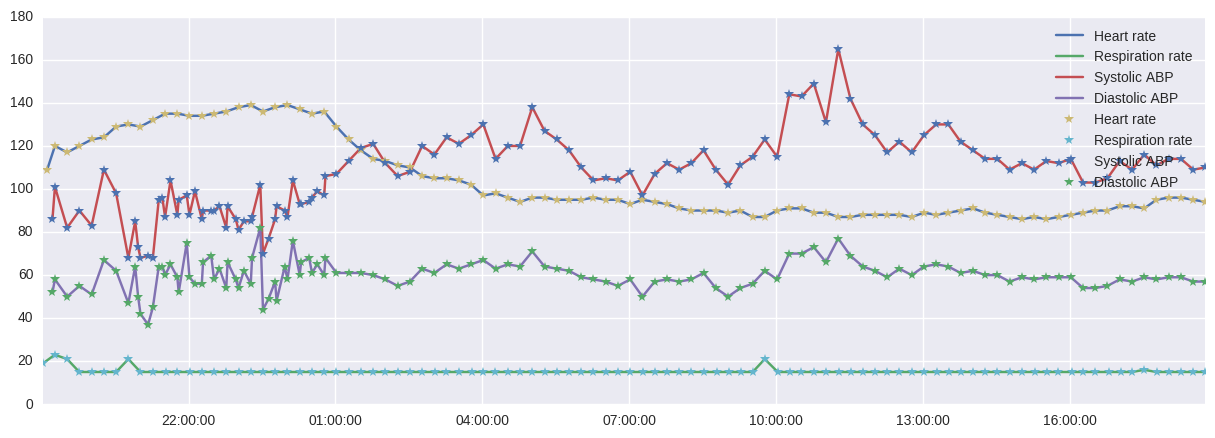

In [226]:
plot_waves(conn, 2744589, '2014-06-24')

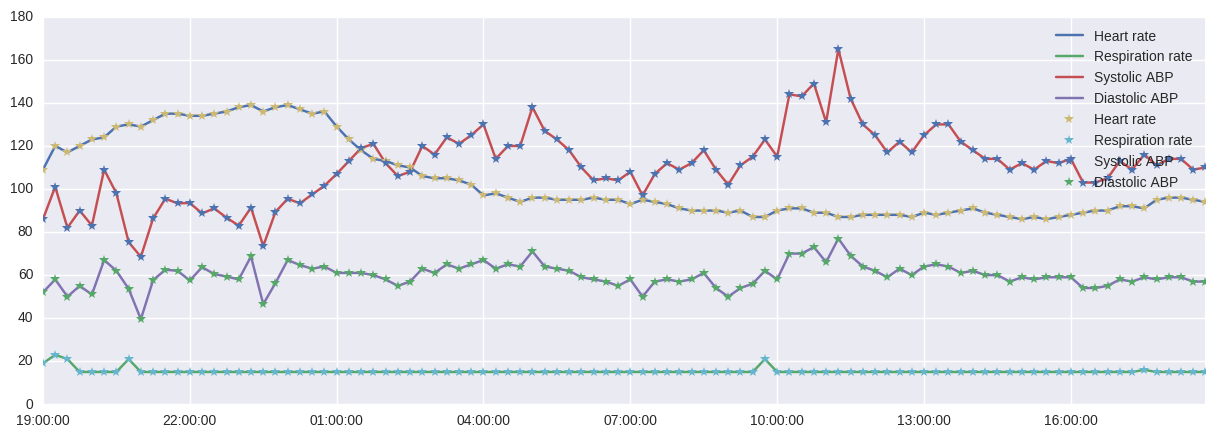

In [232]:
hr, rr, abps, abpd = normalize_waves(conn, 2744589, '2014-06-24', 96)
list_waves = [hr, rr, abps, abpd]
list_labels = ['Heart rate', 'Respiration rate', 'Systolic ABP', 'Diastolic ABP']
plot_waves_from_lists(list_waves, list_labels)

# Second case : number of points is about 60 and less

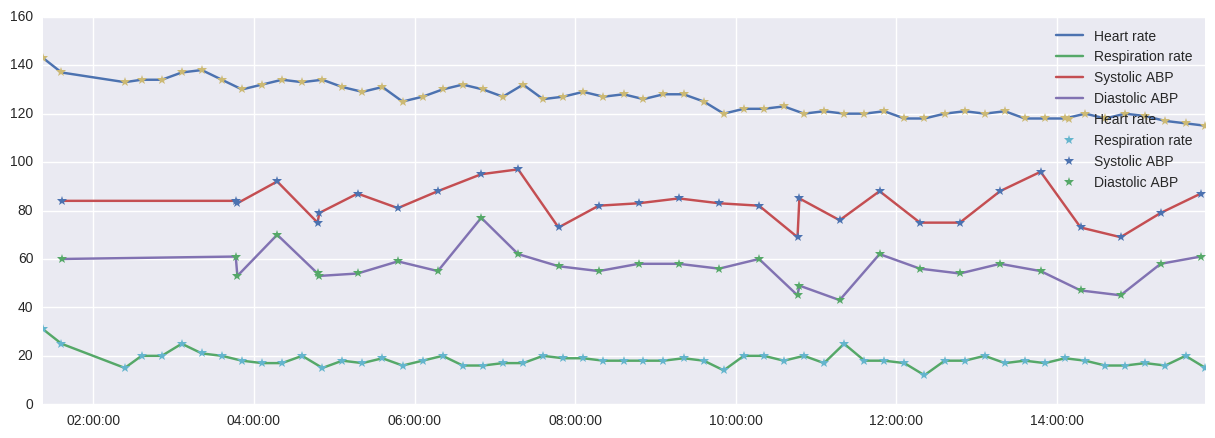

In [234]:
# Other case : 2818365 2014-05-16
plot_waves(conn, 2818365, '2014-05-16')

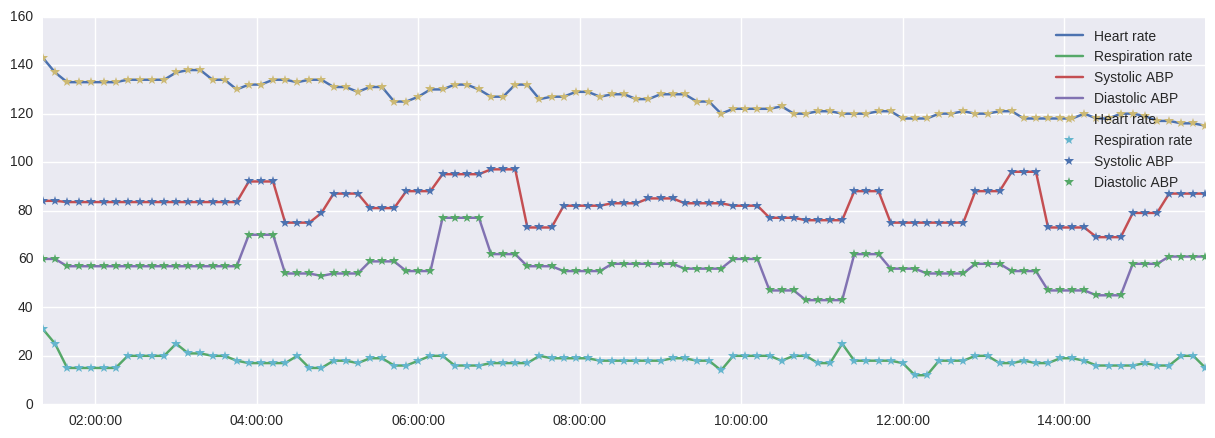

In [235]:
hr, rr, abps, abpd = normalize_waves(conn, 2818365, '2014-05-16', 96)
list_waves = [hr, rr, abps, abpd]
list_labels = ['Heart rate', 'Respiration rate', 'Systolic ABP', 'Diastolic ABP']
plot_waves_from_lists(list_waves, list_labels)

# Third case : number of points is more than 96

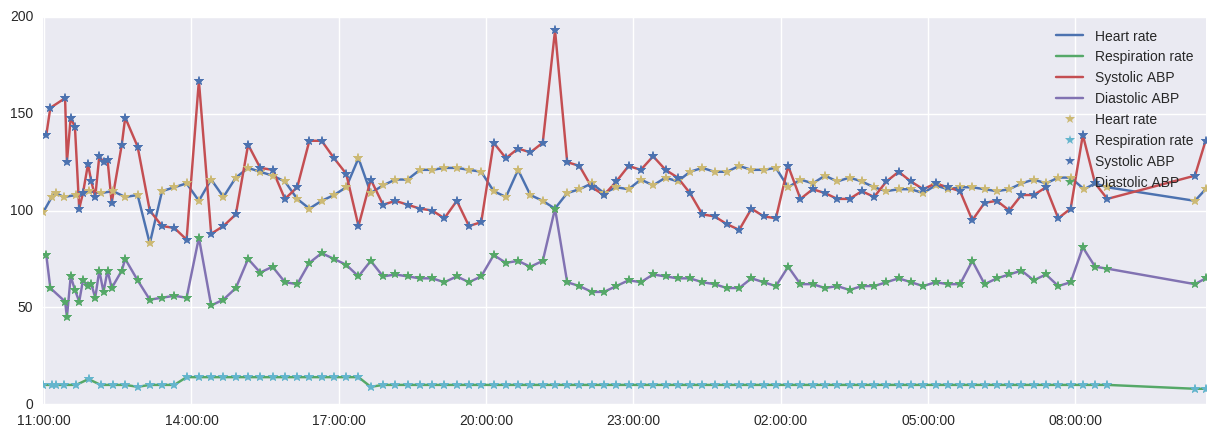

In [236]:
# 2773618 2014-05-06
plot_waves(conn, 2773618, '2014-05-06')

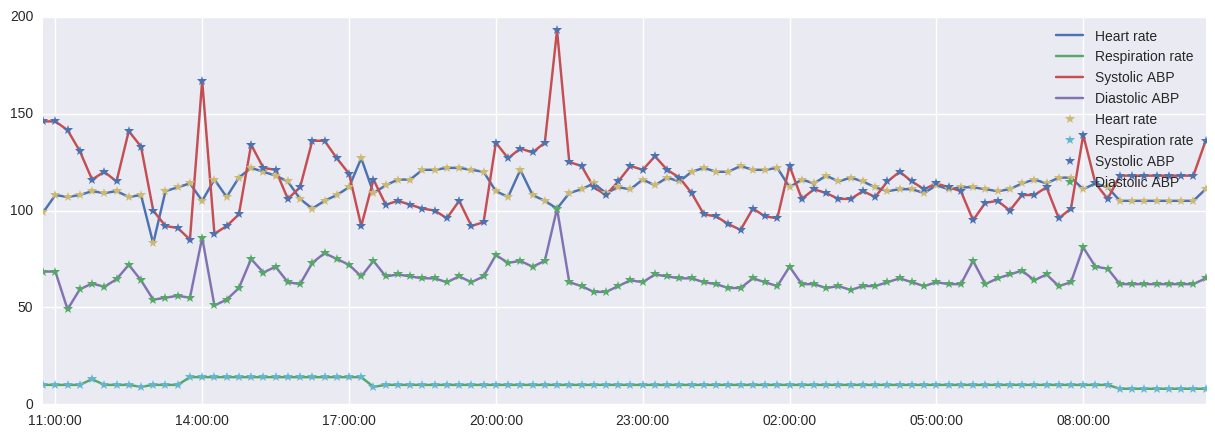

In [237]:
hr, rr, abps, abpd = normalize_waves(conn, 2773618, '2014-05-06', 96)
list_waves = [hr, rr, abps, abpd]
list_labels = ['Heart rate', 'Respiration rate', 'Systolic ABP', 'Diastolic ABP']
plot_waves_from_lists(list_waves, list_labels)